In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from feature_engine.datetime import DatetimeFeatures

Rides EDA

1. aggregated ride counts average for each hour and day of the week
2. aggregated ride counts for each hour and season of the year
3. autocorrelation (full and partial) for hourly ride counts
4. start-end pairings (TO DO)

In [3]:
rides_train = pd.read_csv("data/rides_train_clean.csv")

In [44]:
ride_counts = rides_train.groupby('start_hour')['start_lat'].count().reset_index().rename(columns={'start_lat':'ride_count'})
ride_counts['start_hour'] = pd.to_datetime(ride_counts['start_hour'])

In [51]:
def add_time_features(ride_counts, time_col):
    """add a bunch of useful time-related features"""

    season_month = {12:'Winter', 1:'Winter', 2:'Winter',
                    3:'Spring', 4:'Spring', 5:'Spring',
                    6:'Summer', 7:'Summer', 8:'Summer',
                    9:'Autumn', 10:'Autumn', 11:'Autumn'}

    ride_counts['date'] = ride_counts.loc[:, time_col].dt.date

    dtfs = DatetimeFeatures(
                variables=time_col,
                features_to_extract=["year", "quarter", "month",
                                     "hour", "day_of_week", "weekend"],
                drop_original=False,
    )
    ride_counts = dtfs.fit_transform(ride_counts)
    ride_counts.columns = ride_counts.columns.str.removeprefix('time_')
    ride_counts.loc[:, 'season'] = ride_counts['month'].map(season_month)

    holidays = calendar().holidays(start=ride_counts[time_col].min(), end=ride_counts[time_col].max())
    ride_counts['is_holiday'] = pd.to_datetime(ride_counts.loc[:, 'date']).isin(holidays)
    ride_counts['is_workday'] = ~(ride_counts['weekend'] | ride_counts['is_holiday'])

    return ride_counts

In [52]:
ride_counts = add_time_features(ride_counts, 'time')

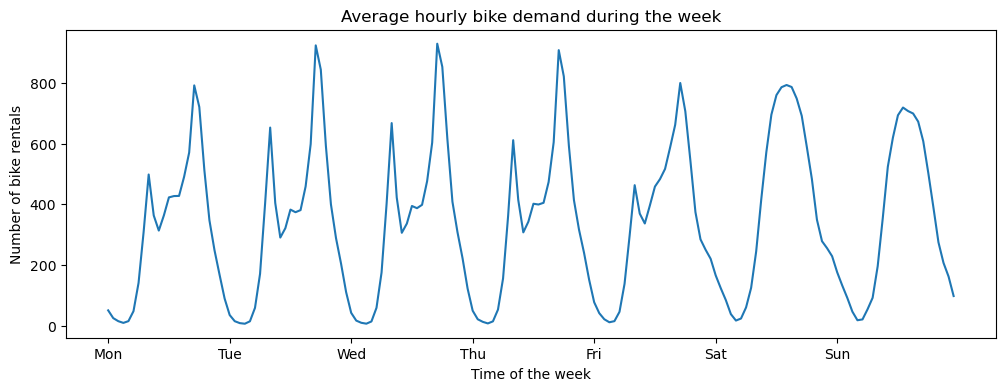

In [55]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = ride_counts.groupby(["day_of_week", "hour"])["ride_count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

2. Seasonal variation

The seaborn plot below shows a clear annual seasonality to the data as well, with Winter months (D, J, F) experiencing much lower average ride volume than other seasons.
All seasons show a similar workday vs non-workday (weekend/holiday) pattern. 
Workday patterns are likely driven by commuters, with rush hour peaks. Evening rush hour appears consistently higher than morning.

/home/studio-lab-user/.conda/envs/scipy/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


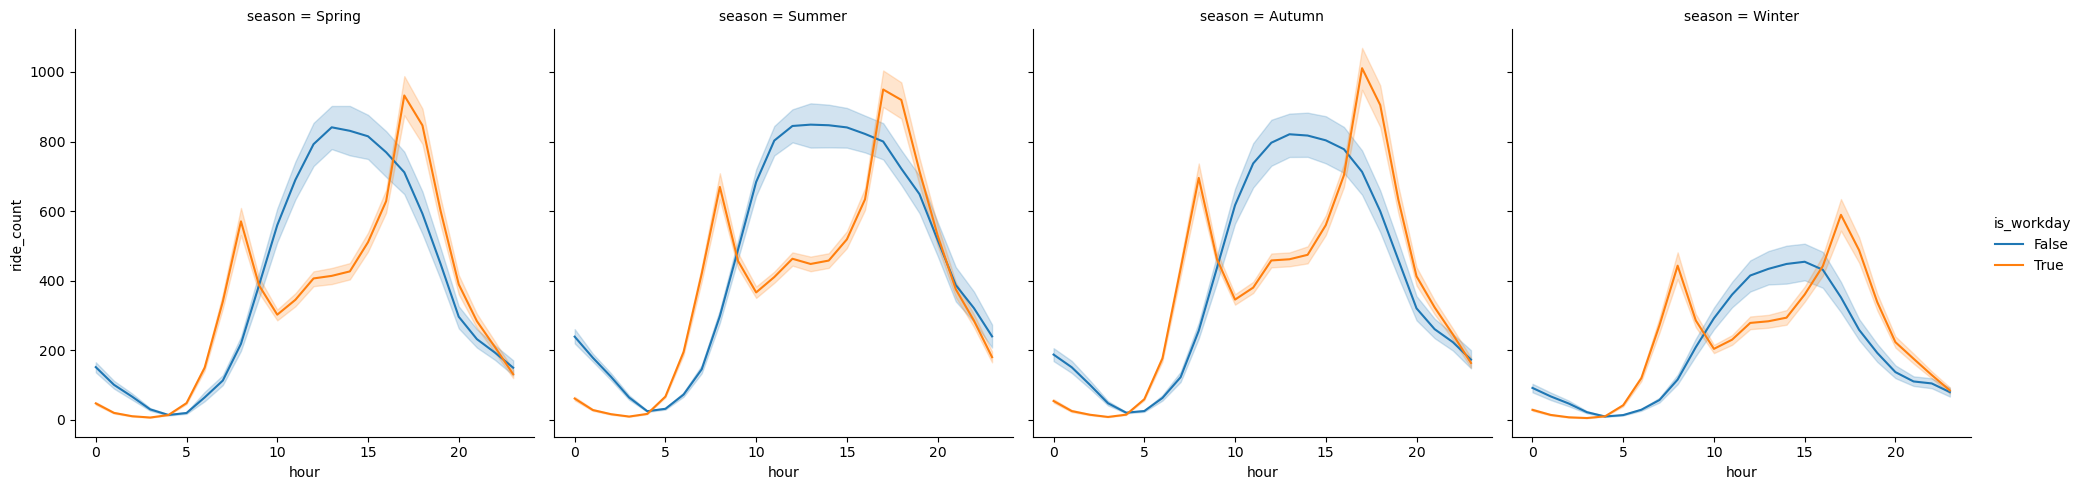

In [60]:
s = sns.relplot(
        data = ride_counts,
        x = "hour",
        y = "ride_count",
        hue = "is_workday",
        col = "season",
        kind = "line",
)